In [1]:
# import all relevant libraries dependencies and set up the backend
import qsharp
import time
import progressbar
import numpy as np
import matplotlib.pyplot as plt
from qsharp import Result
import exact_diagonalisation.ed_ising as ED 
from Quantum.Isinglongrange import Evolve, EvolveSingleTimestepDummy
# from Quantum.Ising2d import Evolve, EvolveSingleTimestepDummy

c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2'
c6_a = '#82E0AA'
c7_a = '#9966CC'
c8_a = '#7FFFD4'
c9_a = '#66FF00'
c10_a = '#8B008B'
c11_a = '#000000'
colors = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

Preparing Q# environment...
.

# Time Evolution

Assumes an L x W lattice of sites and uses lists length LW to specify hx and hz for each site and a matrix J (LW x LW) specified for the couplings. Evolves under Hamiltonian
\begin{equation}\label{eq:}
H = -\sum_{i, j>i} J_{ij} \sigma_z^i\sigma_z^j - \sum_{i}hx_i \sigma_x^i - \sum_{i}hz_i\sigma_z^i
\end{equation}

Expects initial state of correct shape in 0s and 1s (Z basis) to be specified. An initial state in the X basis can be used instead by specifying the x_rot parameter

In [5]:
# define system parameters
attempt_ED = True
xinit = False
xmeas = False
nnonly = False
parallel = True
p = {}
p['L'] = L = 3 # system length
p['W'] = W  = 2 # system width
p['N'] = p['L'] * p['W'] # number of system in the system
p['hx'] = hx = np.array([1. for _ in range(L * W)]) # transverse Ising field for each site 
p['hz'] = hz = np.array([0. for _ in range(L * W)]) # longitudinal Ising field for each site 

couplings = [0., 1., 0.5, 0.1, 0.]
J = [[0. for _ in range(L * W)] for _ in range(L * W)]
for i in range(L * W):
    for j in range(L * W):
        s_r, s_c = i // W, i % W
        t_r, t_c = j // W, j % W
        if s_r == t_r:
            h_dist = min([abs(s_c - t_c), W - abs(s_c - t_c)])
            J[i][j] = couplings[h_dist]
        elif s_c == t_c:
            v_dist = min([abs(s_r - t_r), L - abs(s_r - t_r)])
            J[i][j] = couplings[v_dist]
p['J'] = np.asarray(J) # Ising interaction for all sites (i,j)
p['t_initial'] = 0 # begin of time evolution
p['dt'] = dt = 0.01 # time-step
p['t_final'] = total_time = 1.0 # end of time evolution
times = np.linspace(0, total_time, num=11)
ave = 500 # measurement count for qsharp meas
initial_state = [[0, 1, 0, 1, 1, 0],]
flat_initial_state = [item for sub in initial_state for item in sub]
state_table = ED.generate_state_table(p)
if L * W > 9:
    attempt_ED = False

In [6]:
# do exact evolution
if attempt_ED:
    tic = time.time()
    sim, state_table = ED.evolve(p, state_table, flat_initial_state, kind="list", trotterised=True, xinit=xinit)
    toc = time.time()
    print("Exact evolution took ", toc-tic, "s")
    basis = 'X' if xmeas else 'Z'

Exact evolution took  0.4904940128326416 s


In [7]:
# do qsharp evolution
tic = time.time()
result = np.zeros((len(times), *np.array(initial_state).shape))
progress_bar = progressbar.ProgressBar(max_value=ave)
points_taken = 0
for _ in range(ave):
    for i, t in enumerate(times):
        res = Evolve.simulate(
                initialState=flat_initial_state, time=t, dt=dt, g=list(hx), h=list(hz), J=J,
                nnonly=nnonly, parallel=parallel, xinit=xinit, xmeas=xmeas)
        result[i] += np.array(res).reshape(np.array(initial_state).shape) / ave
    points_taken += 1
    progress_bar.update(points_taken)
toc = time.time()
print("Q# Evolution took {} mins {} s".format(int((toc-tic) // 60), int((toc-tic) % 60)))

100% (500 of 500) |######################| Elapsed Time: 0:23:16 ETA:  00:00:00

Q# Evolution took 23 mins 23 s


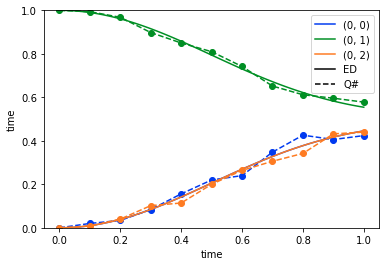

In [8]:
# plot
fig = plt.figure()
qubits = [(0, 0), (0, 1), (0, 2)]
for i, q in enumerate(qubits):
    site = p['W']*q[0]+q[1]
    if attempt_ED:
        site_res = 1 - (sim['{}i Site {}'.format(basis, site)] + 1) / 2
        plt.plot(sim['Time'], site_res, label='{}'.format(q), marker='', linestyle='-', color=colors[i])
    plt.plot(times, result[:, q[0], q[1]], color=colors[i], marker='o', linestyle='--')
plt.ylim(0, 1)  
handles, labels = fig.axes[0].get_legend_handles_labels()
handles = list(handles) + [plt.Line2D((0, 1), (0, 0), color='k', linestyle='-'),
                           plt.Line2D((0, 1), (0, 0), color='k',linestyle='--')]
labels = list(labels) + ['ED', 'Q#']
plt.xlabel('time')
plt.ylabel('time')
plt.legend(handles, labels)

# Resource Estimation

Estimate the resources for the full evolution (1st order) and for a single timestep. Currently the depth only measures T gates of which there are none.

In [9]:
# estimate resources
full_gatecount = Evolve.estimate_resources(
                    initialState=flat_initial_state, time=t, dt=dt, g=list(hx), h=list(hz), J=J,
                    nested=nested, nnonly=nnonly, xinit=xinit, xmeas=xmeas)
timestep_gatecount = EvolveSingleTimestepDummy.estimate_resources(
                        nSites=len(flat_initial_state), dt=dt, g=list(hx), h=list(hz), J=J,
                        nested=nested, nnonly=nnonly)

print('Full Evolution')
print(*['\t{}: {}\n'.format(k, v) for k, v in full_gatecount.items()])
print('Single Timestep')
print(*['\t{}: {}\n'.format(k, v) for k, v in timestep_gatecount.items()])

Full Evolution
	CNOT: 1200
 	QubitClifford: 1
 	R: 1400
 	Measure: 4
 	T: 0
 	Depth: 0
 	Width: 4
 	BorrowedWidth: 0

Single Timestep
	CNOT: 12
 	QubitClifford: 0
 	R: 14
 	Measure: 0
 	T: 0
 	Depth: 0
 	Width: 4
 	BorrowedWidth: 0

